## Aplicação do teste de Degradação em dataset sobre vendas.
### O teste que aplicamos busca estimar por quanto tempo após treinado, um modelo de Machine Learning ficaria com a performance estável. Avaliamos as duas métricas: Erro Absoluto Médio (MAE) e Erro Quadrático Médio (MSE).
### O modelo desenvolvido foi o de Regressão Linear com o algorítmo Random Forest.

In [1]:
# Importando as bibliotecas necessárias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Leitura dos dados.
data = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
data = data.filter(regex=r'Product|W')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


In [3]:
data.shape

(811, 53)

In [4]:
## Transformando o dataset em um único dataset com 42172 linhas.
melt = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['Week', 'Product_Code'])
melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [5]:
melt.shape

(42172, 3)

In [6]:
melt2 = melt.copy()
melt2['Last_Week_Sales'] = melt2.groupby(['Product_Code'])['Sales'].shift()
melt2['Last_Week_Diff'] = melt2.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt2 = melt2.dropna()
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


In [7]:
# Deletando a coluna 'Product_Code' de melt2.
melt2 = melt2.drop('Product_Code', axis=1)

In [8]:
melt2.shape

(40550, 4)

In [10]:
# Quantas semanas tem no total?
melt2['Week'].nunique()

50

In [11]:
melt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40550 entries, 1622 to 42171
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Week             40550 non-null  int32  
 1   Sales            40550 non-null  int64  
 2   Last_Week_Sales  40550 non-null  float64
 3   Last_Week_Diff   40550 non-null  float64
dtypes: float64(2), int32(1), int64(1)
memory usage: 1.4 MB


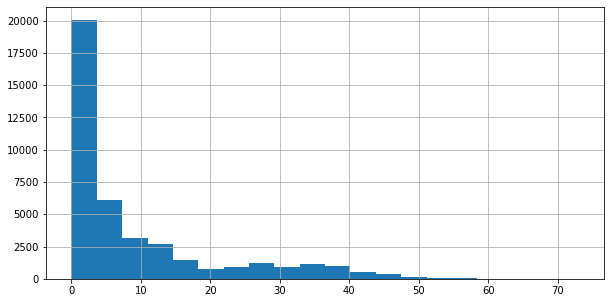

In [12]:
melt2['Sales'].hist(bins=20, figsize=(10,5))

In [13]:
## Todas as variáveis são numéricas. Então o dataset está pronto para a Regressão.

### Criando o modelo de Regressão.

### Executando o modelo Random Forest com as 4 variáveis.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import math

In [15]:
X = melt2.drop('Sales', axis=1)
y = melt2['Sales']

In [16]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.6, test_size=0.40, random_state=0)

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
sc = StandardScaler()
train_X1 = sc.fit_transform(train_X)
test_X1 = sc.transform(test_X)

In [19]:
model = RandomForestRegressor(random_state = 0, n_estimators=100, oob_score=True)
model.fit(train_X1, train_y)
pred_y = model.predict(test_X1)
acc_random_forest = round(model.score(train_X1, train_y) * 100, 1)

In [20]:
print('MAE: ',round(metrics.mean_absolute_error(test_y,pred_y),1))
print('MSE: ',round(metrics.mean_squared_error(test_y,pred_y),1))
print('RMSE: ',round(math.sqrt(metrics.mean_squared_error(test_y,pred_y)),1))
print('r^2: ',round(acc_random_forest,1))
print("oob score:", round(model.oob_score_,4)*100, "%")

MAE:  2.6
MSE:  16.6
RMSE:  4.1
r^2:  97.1
oob score: 87.78 %


### Teste de Degradação do Modelo

### Testando, passo a passo, o cálculo do MAE e do MSE.

In [21]:
#s = 0
#for s in range(2, 51):
 #   if(s < 6)
test_mes1 = X.query('Week <= 5')
test_mes1

,Week,Last_Week_Sales,Last_Week_Diff
1622,2,12.0,1.0
1623,2,6.0,-1.0
1624,2,11.0,4.0
1625,2,8.0,-4.0
1626,2,5.0,-3.0
...,...,...,...
4861,5,0.0,0.0
4862,5,1.0,1.0
4863,5,1.0,1.0
4864,5,0.0,-1.0


In [22]:
pred_1 = model.predict(test_mes1)

In [23]:
pred_1.shape

(3244,)

In [24]:
test_mes1.shape

(3244, 3)

In [25]:
sales = melt2.query('Week <= 5')['Sales']
sales.shape

(3244,)

In [26]:
print('MAE: ',round(metrics.mean_absolute_error(sales, pred_1),1))
print('MSE: ',round(metrics.mean_squared_error(sales, pred_1),1))

MAE:  24.7
MSE:  862.5


In [27]:
test_mes2 = test_X.query('Week >= 6 & Week <= 9')
test_mes2

,Week,Last_Week_Sales,Last_Week_Diff
5640,6,9.0,-9.0
6024,7,0.0,-1.0
6687,8,20.0,5.0
6908,8,0.0,0.0
6613,8,3.0,-3.0
...,...,...,...
5573,6,1.0,0.0
6758,8,3.0,-1.0
6158,7,2.0,-3.0
7085,8,2.0,0.0


In [28]:
test_mes2.index

Int64Index([5640, 6024, 6687, 6908, 6613, 5902, 6960, 5134, 5720, 6477,
            ...
            6666, 6488, 7951, 7167, 6408, 5573, 6758, 6158, 7085, 7480],
           dtype='int64', length=1303)

In [29]:
sales2 = test_y.filter(items = test_mes2.index)

In [33]:
sales2

5640    15
6024     2
6687    17
6908     0
6613     5
        ..
5573     0
6758     1
6158     1
7085     0
7480    37
Name: Sales, Length: 1303, dtype: int64

In [34]:
pred_2 = model.predict(test_mes2)

In [35]:
#sales2 = melt2.query('Week >= 6 & Week <= 9')['Sales']

In [36]:
print('MAE: ',round(metrics.mean_absolute_error(sales2, pred_2),1))
print('MSE: ',round(metrics.mean_squared_error(sales2, pred_2),1))

MAE:  24.4
MSE:  850.3


In [37]:
test_mes3 = X.query('Week >= 10 & Week <= 13')

In [38]:
pred_3 = model.predict(test_mes3)

In [39]:
sales3 = melt2.query('Week >= 10 & Week <= 13')['Sales']

In [40]:
print('MAE: ',round(metrics.mean_absolute_error(sales3, pred_3),1))
print('MSE: ',round(metrics.mean_squared_error(sales3, pred_3),1))

MAE:  24.7
MSE:  863.5


### Cálculo do MAE e MSE para os 13 meses.

### Se o MAE e o MSE estiverem aumentando com o tempo, é sinal de que o modelo pode estar sofrendo degradação. Ou seja, uma diminuição no seu poder de previsão.

In [41]:
def teste_mes(mes):
    week_inicio = 4 * mes - 2
    week_fim = 4 * mes + 1
    test_mes = test_X.query('Week >= ' + str(week_inicio) + ' & Week < ' + str(week_fim))
    print(week_inicio, week_fim)
    sales_mes = test_y.filter(items = test_mes.index)
    teste_mes = sc.transform(test_mes)
    pred_mes = model.predict(test_mes)
   # sales_mes = test_y.query('Week >= ' + str(4 * mes - 2) + ' & Week <= ' + str(4 * mes + 1) + '')#['Sales']
    return round(metrics.mean_absolute_error(sales_mes, pred_mes),1), round(metrics.mean_squared_error(sales_mes, pred_mes),1), round(acc_random_forest,1)

In [42]:
test_y

37113    42
36301    27
9831     11
35890     7
1893      0
         ..
38008     1
4005      0
37039    13
17752     0
34532     0
Name: Sales, Length: 16220, dtype: int64

In [43]:
resultado = pd.DataFrame(columns=['Mes','MAE','MSE','r_quadrado'])
for n in range(1,14):
    mae_mes, mse_mes, r_squared_mes = teste_mes(n)
    resultado.loc[n] = [n,mae_mes,mse_mes,r_squared_mes]
    resultado['Mes'] = resultado['Mes'].astype('int')

2 5
6 9
10 13
14 17
18 21
22 25
26 29
30 33
34 37
38 41
42 45
46 49
50 53


In [44]:
resultado

,Mes,MAE,MSE,r_quadrado
1,1,24.1,838.3,97.1
2,2,24.5,856.3,97.1
3,3,24.3,849.8,97.1
4,4,25.0,884.4,97.1
5,5,25.8,925.6,97.1
6,6,25.7,896.2,97.1
7,7,28.4,1069.7,97.1
8,8,26.4,938.7,97.1
9,9,25.7,899.4,97.1
10,10,26.4,941.7,97.1


### O R_quadrado não aumenta ao longo dos meses.

### Construção dos gráficos de barra.

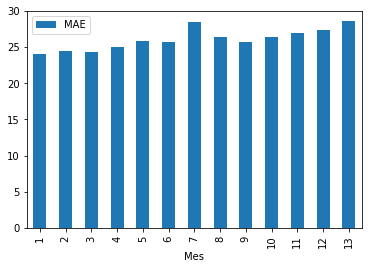

In [45]:
resultado.plot('Mes','MAE', kind='bar')

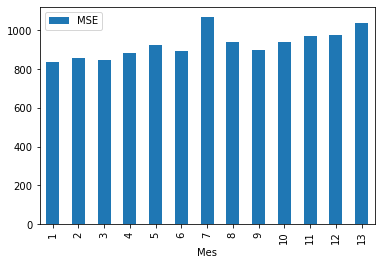

In [46]:
resultado.plot('Mes','MSE', kind='bar')

### Cáculo da Variação percentual do MAE em 13 meses.

In [47]:
variacao_MAE = (resultado.iloc[12]['MAE'] - resultado.iloc[0]['MAE']) / resultado.iloc[0]['MAE']

In [48]:
variacao_MAE

0.18672199170124482

### Cálculo da Variação percentual do MSE em 13 meses.

In [49]:
variacao_MSE = (resultado.iloc[12]['MSE'] - resultado.iloc[0]['MSE']) / resultado.iloc[0]['MSE']

In [50]:
variacao_MSE

0.23655016104020035

### Comparação entre as Variações do Sales com Dr. Consulta (Caso desenvolvido anteriormente).

In [51]:
data = {'Sales': [variacao_MAE*100, variacao_MSE*100], 'Dr Consulta': [7.7, 6.7]}

comparacao = round(pd.DataFrame(data, columns=['Sales','Dr Consulta'], index=['Variação MAE','Variação MSE']),1)
comparacao

,Sales,Dr Consulta
Variação MAE,18.7,7.7
Variação MSE,23.7,6.7


In [52]:
melt2['Week'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [53]:
test_X

,Week,Last_Week_Sales,Last_Week_Diff
37113,45,37.0,11.0
36301,44,36.0,5.0
9831,12,12.0,3.0
35890,44,5.0,-2.0
1893,2,0.0,0.0
...,...,...,...
38008,46,2.0,0.0
4005,4,0.0,0.0
37039,45,11.0,4.0
17752,21,0.0,0.0


### Conclusões:
### Encontramos variações altas de MSE e MAE no modelo de Regressão Linear para o dataset de vendas em comparação com as variações no Dr. Consulta. Isso indica que está ocorrendo degradação do modelo para este período de tempo.

### Referências:
### https://nathaliatito.medium.com/scikit-learn-ou-statsmodels-avaliando-meu-modelo-de-regress%C3%A3o-f4c04b361fa7
### https://www.youtube.com/c/MarioFilhoML/videos
### www.exemplarias.com